# Replicate Meridional Wind Analysis in Danielson et al. 2020

Replicate the calculation shown in Figure 15 of Danielson et al. 2020 which shows the seasonal difference between the meridional winds over the time periods 1979-2013 and 2014-2018. Compare this with plots that calculate the difference if you expand the 'recent' analysis period until 2021.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import numpy as np

## Set lat,lon for analysis

In [3]:
lats = np.array([50, 80])
lons = np.array([160, 230])

## Set observational paths

In [4]:
v10_dir = '/work/Marion.Alberty/data/ERA5_pp/v_10m/'

## Get file lists

In [5]:
flist_v10 = glob(f'{v10_dir}ERA5_monthly_v_10m_*.nc')

## Read in observational data

In [6]:
def fix_latlon(ds):
    # Rename to lat, lon
    ds = ds.rename({'longitude':'lon','latitude':'lat'})
    # reindex for increasing lat
    ds = ds.reindex(lat=list(reversed(ds.lat)))
    return ds

In [7]:
# Winds
DS_v10 = fix_latlon(xr.open_mfdataset(flist_v10,engine='netcdf4')).sel(
    lon=slice(lons[0],lons[1]),lat=slice(lats[0],lats[1]))

## Make time averages

In [8]:
p0 = DS_v10.sel(time=slice('1979','2013')).groupby('time.month').mean()

In [9]:
p1 = DS_v10.sel(time=slice('2014','2018')).groupby('time.month').mean()

In [10]:
p2 = DS_v10.sel(time=slice('2014','2021')).groupby('time.month').mean()

## Calculate the differences

In [11]:
da1 = (p1 - p0)['v10']

In [12]:
da2 = (p2 - p0)['v10']

## Plot differences for October, November, December
The first row of plots should be the differences using the Danielson time periods while the second row shows the differences if you extend the record to the present.

In [13]:
def bering_map(da,ax):
    # Specify data projection
    crs = ccrs.PlateCarree()
    
    # Pull variables for plotting
    x = da['lon']
    y = da['lat']
    z = da
    
    im = ax.pcolormesh(x,y,z,transform=crs,cmap='cmo.balance',vmin=-2,vmax=2)
    # Zoom in around the Bering Strait
    ax.set_extent([175, 210, 55, 75], crs=crs)

    # Add a land mask to your plot, as well as grid lines and coastlines
    ax.add_feature(cfeature.LAND,zorder=9,facecolor='darkgray')
    ax.gridlines(draw_labels=True,dms=True,x_inline=False,y_inline=False,
                 crs=crs,xlocs=[170,180,-170,-160,-150,-140])
    ax.coastlines()
    return im

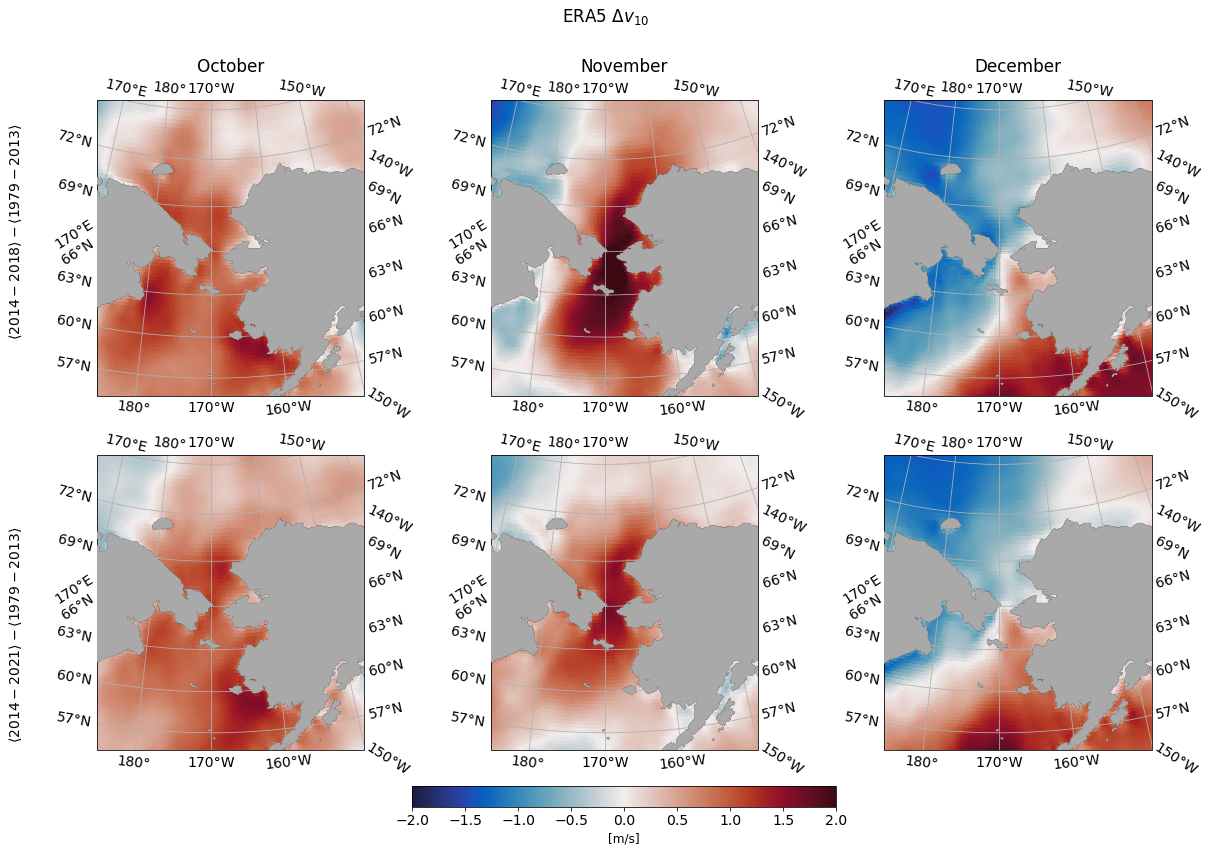

In [14]:
# Create a figure and axes using matplotlib
fig,ax = plt.subplots(figsize=(20,13),nrows=2,ncols=3,
                      subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-170)})
# step through months
for (mon,col) in zip([10,11,12],[0,1,2]):
    # Danielson time periods
    _  = bering_map(da1.sel(month=mon),ax[0,col])
    # To present day
    im = bering_map(da2.sel(month=mon),ax[1,col])

# Add colorbar
cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.03,pad=0.05)
cbar.set_label('[m/s]',fontsize=12)

# Additional formatting
fig.suptitle(r'ERA5 $\Delta v_{10}$')
ax[0,0].set_title('October')
ax[0,1].set_title('November')
ax[0,2].set_title('December')

fig.text(0.09, 0.74, r'$\langle 2014-2018 \rangle - \langle 1979-2013 \rangle$',
             ha='center', va='center', rotation='vertical')
fig.text(0.09, 0.31, r'$\langle 2014-2021 \rangle - \langle 1979-2013 \rangle$',
             ha='center', va='center', rotation='vertical')
plt.show()